# Inhibitor effect on clusters

In [8]:
# If problems installing slingshot
# sudo apt-get update
# sudo apt-get install libglu1-mesa-dev 
# sudo apt-get install freeglut3-dev
# sudo apt-get install mesa-common-dev
# then
# install.packages("rgl")
# BiocManager::install("slingshot")
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(reshape2)

In [9]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/R4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] reshape2_1.4.4     cowplot_1.0.0      pheatmap_1.0.12    ggplot2_3.3.0     
[5] destiny_3.2.0      RColorBrewer_1.1-2 dplyr_0.8.5       

loaded via a namespace (and not attached):
  [1] bitops_1.0-6                matrixStats_0.56.0         
  [3] xts_0.12-0                  GenomeInfoDb_1.24.0      

# Process with Seurat from raw

In [10]:
metadata = read.csv('figures_organoid_confInhibitors/Donor44/barcode_metadata.csv', stringsAsFactors = F)
head(metadata)

,index,Days,Donor,Donor_demu,G2M_score,Inhibition,S_score,Sample,Treatment,batch,⋯,percent_mito,phase,scrublet_cluster_score,scrublet_score,tp,zscore,clusters_noIn,clusters_AllInh,clusters,clusters2
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<int>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,WSSS_END8730359-GGGATCCGTGAAAGTT,6.000,B044,B044,1.77416000,N/I,0.4712052,WSSS_END8730359,E+P,0,⋯,0.08538593,G2M,0.07110092,0.44247788,NaN,-0.5874722,proliferative,inhibitor,proliferative,proliferative
2,WSSS_END8730167-ACTTTCACATTCACAG,5.000,B044,B044,1.01174010,N/I,1.6101978,WSSS_END8730167,E+P,0,⋯,0.10971367,S,0.14736842,0.08363636,NaN,0.8808317,KRT5_LRG6,KRT5_LRG6,inter_PGRneg,inter_PGRneg
3,WSSS_END8730167-GAAGGGTTCCGGCAGT,5.000,B044,B044,1.41835990,N/I,1.1960039,WSSS_END8730167,E+P,0,⋯,0.18210500,G2M,0.11952063,0.06796117,NaN,0.2300341,Inter_PGRneg,proliferative,inter_PGRneg,inter_PGRneg
4,WSSS_END8729880-TCCTTCTCAGTGTACT,1.125,B044,B044,-0.03015867,N/I,0.2869394,WSSS_END8729880,E,0,⋯,0.09298436,S,0.16083916,0.09004739,NaN,1.5628061,Inter_PGRneg,inhibitor,inter_PGRneg,inter_PGRneg
5,WSSS_END8730359-TATCTTGTCACCTGTC,6.000,B044,B044,0.33218786,N/I,-0.3298161,WSSS_END8730359,E+P,0,⋯,0.07185629,G2M,0.10256410,0.06861642,NaN,0.3127446,Secretory,inhibitor,inter,inter
6,WSSS_END8729879-GACGCTGTCTGTTGGA,1.000,B044,B044,0.71839470,N/I,1.9271688,WSSS_END8729879,N/H,0,⋯,0.10906497,S,0.09785203,0.13772455,NaN,-0.2980997,KRT5_LRG6,KRT5_LRG6,KRT5_LRG6,KRT5_LRG6


In [11]:
unique(metadata$Inhibition)

[1] "N/I"        "NOTCH-DBZ"  "WNT-XAV939"

In [12]:
create_contingency_table = function(perturbed_cl, control_cl, perturbed, control){
    if(length(perturbed_cl) == 0 || length(control_cl) == 0){
        perturbed_cl = c(perturbed_cl, '1')
        control_cl = c(control_cl, '1')
        perturbed = c(perturbed, '1')
        control = c(control, '1')
    }
    m = matrix(c(length(perturbed_cl), length(control_cl), 
               length(perturbed),  length(control)), 
             ncol = 2, dimnames = list(c('I', 'C'), c('in_cl', 'total')) )
  return(m)  
}


enrichment = function(perturbed_cl, control_cl, perturbed, control){
  funtable = create_contingency_table(perturbed_cl, control_cl, perturbed, control)
  ft = fisher.test(funtable)
  pvalue = ft$p.value
  estimate = ft$estimate
  conf.int = ft$conf.int
  out = data.frame(pvalue= pvalue, odds.ratio = estimate, min_confint = conf.int[1], max_confint = conf.int[2],  stringsAsFactors = F)
  return(out)
}

test_cluster = function(cl){
    message(cl)
    results = list()
    for (I in inhibitors)
    for (tm in times){
        perturbed = subset(metadata, Inhibition == I & Days == tm)$index
        perturbed_cl = subset(metadata, Inhibition == I & Days == tm & clusters == cl)$index
        control = subset(metadata, Inhibition == 'N/I' & Days == tm)$index
        control_cl = subset(metadata, Inhibition == 'N/I' & Days == tm & clusters == cl)$index
        out = enrichment(perturbed_cl, control_cl, perturbed, control)
        out$inhibitor2 = I
        out$inhibitor = gsub('NOTCH-', '', I) %>% gsub('WNT-', '', .)
        out$id = paste0(out$inhibitor , ' day', tm)
        out$cell_type = cl
        results[[paste0(I, '_day', tm) ]] = out
        
    }
    df = melt(results, id.vars = colnames(results[[1]]))[, -9]
    df$pvalue_adj = p.adjust(df$pvalue)
    df$label = ifelse(df$pvalue_adj < 0.05, '*', '')
    df$label[ df$pvalue_adj < 0.01] = '**'
    df$label[ df$pvalue_adj < 0.001] = '***'
    
    y_max = max(df$max_confint[ ! is.infinite(df$max_confint) ] )
    y_max = log(y_max) + 0.7
    P = ggplot(df, aes(x=id, y=log(odds.ratio), fill = inhibitor, label = label) ) + 
       # scale_y_continuous(limits = log(c(min(df$min_confint[ ! is.infinite(df$min_confint) ]), max(df$max_confint[ ! is.infinite(df$max_confint) ] ) )) ) + 
        scale_y_continuous(limits = c(log(min(df$min_confint[ ! is.infinite(df$min_confint) ])), y_max) ) + 
        geom_bar(stat = 'identity') + 
        geom_point(show.legend = F) + 
        geom_errorbar(mapping = aes(ymin = log(min_confint), ymax = log(max_confint)), width=0.5, size=0.2) +
        geom_text(color = 'black', y = y_max*0.9, size = 6) +
        scale_fill_manual(values = c("#96b2e3",  "#e39696") ) +
        theme_bw(18) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1), 
                             panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
        ggtitle(cl) + xlab('') + ylab('odds ratio (log scale)\n N cells enrichment')
    P
    
    ggsave(filename = paste0('figures_organoid_confInhibitors/Donor44/barplot_inhibitorsenrichment_', cl, '.pdf') )
    return(P)
}

proliferative

Saving 6.67 x 6.67 in image

inter_PGRneg

Saving 6.67 x 6.67 in image

inter

Saving 6.67 x 6.67 in image

KRT5_LRG6

Saving 6.67 x 6.67 in image

inter_PGRpos

Saving 6.67 x 6.67 in image

KRT5_KRT13

Saving 6.67 x 6.67 in image

ciliated

Saving 6.67 x 6.67 in image

glandular_secretory

Saving 6.67 x 6.67 in image

new_secretory

Saving 6.67 x 6.67 in image

secretory_cycling

Saving 6.67 x 6.67 in image



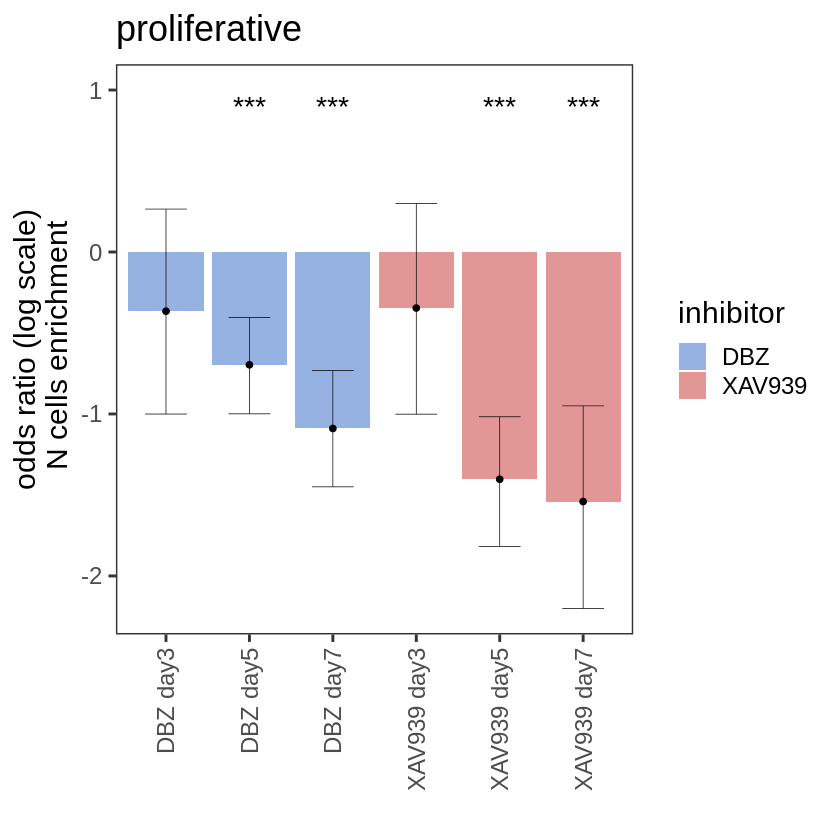

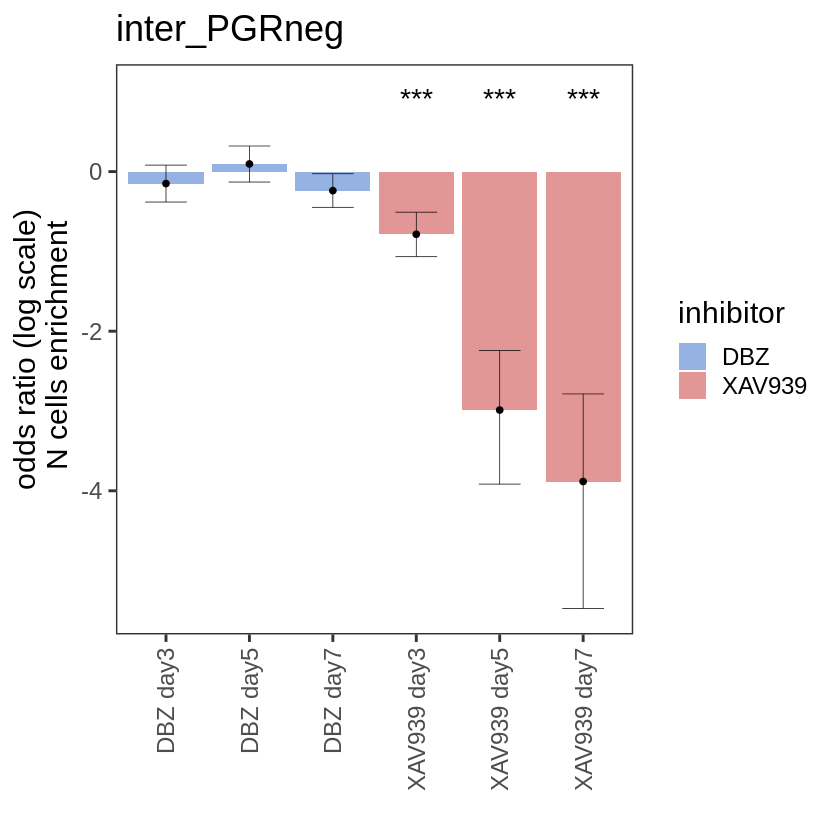

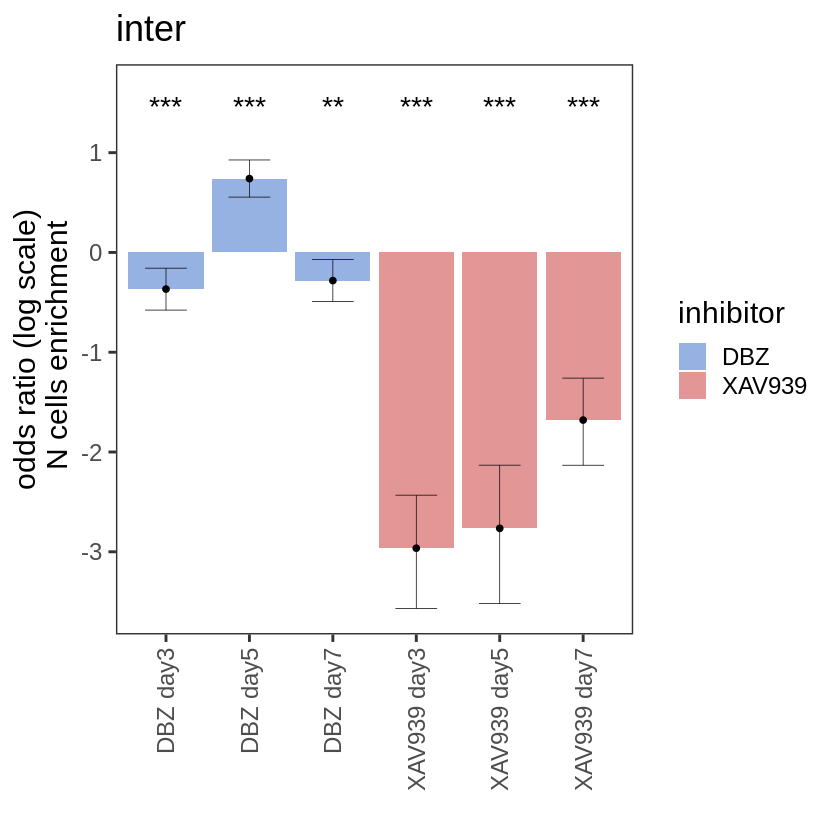

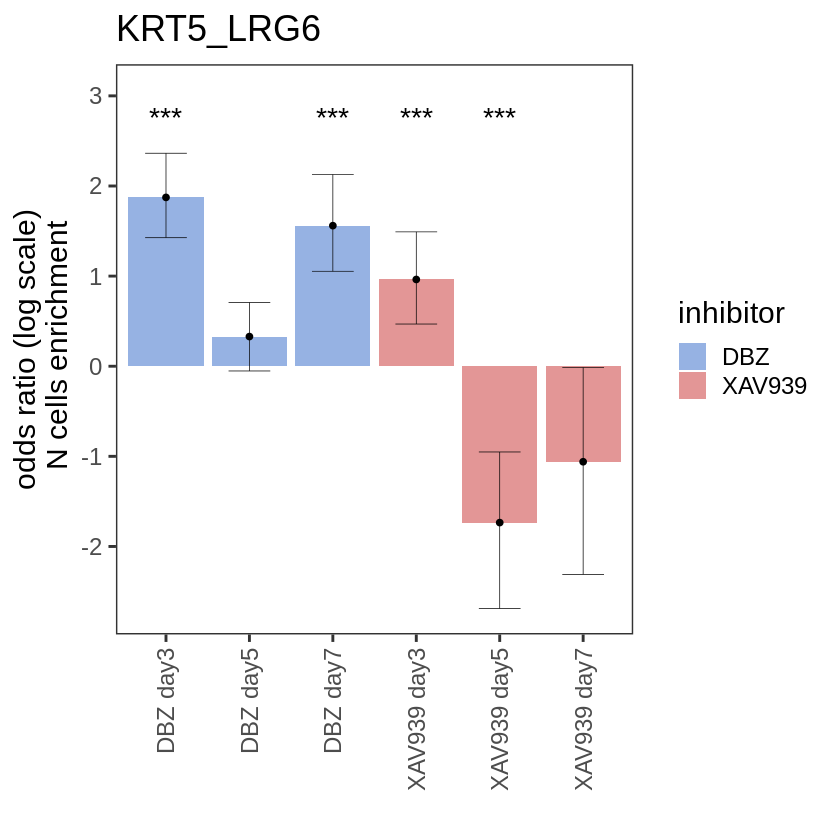

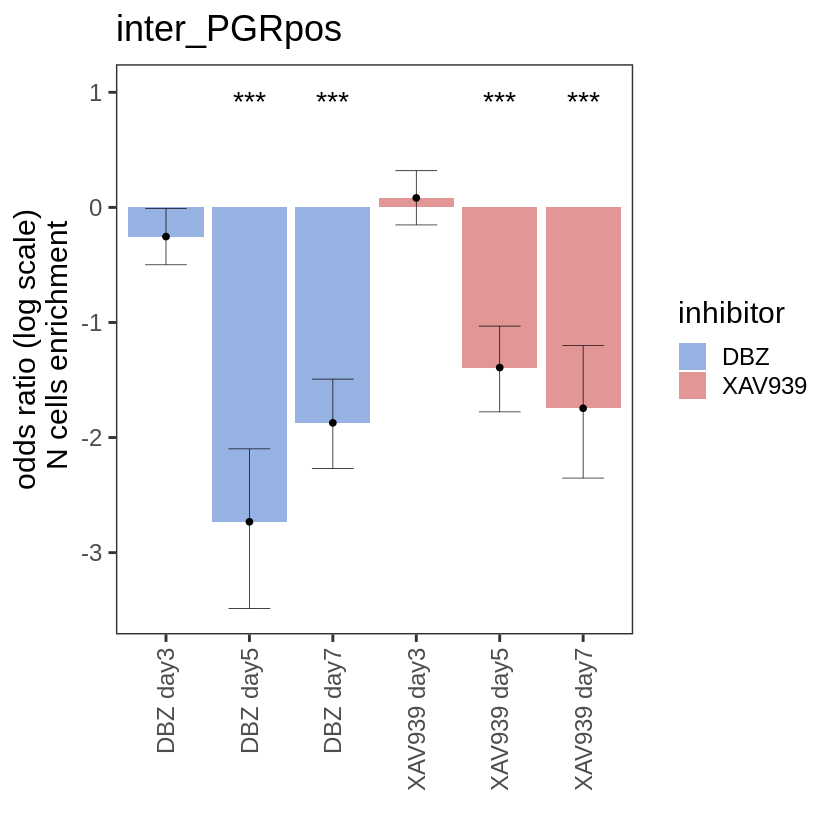

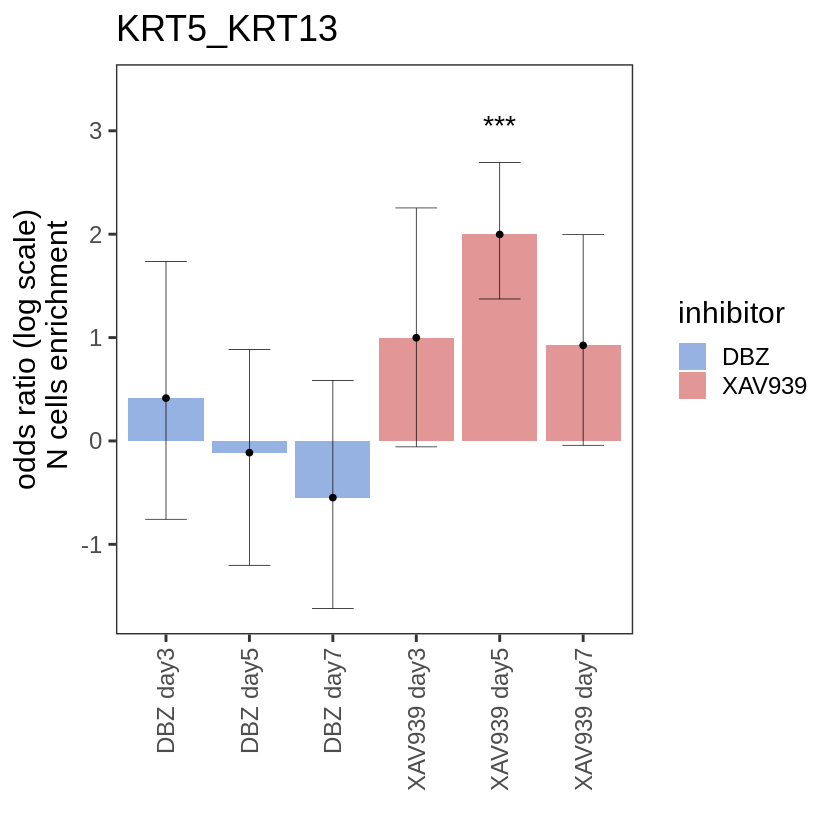

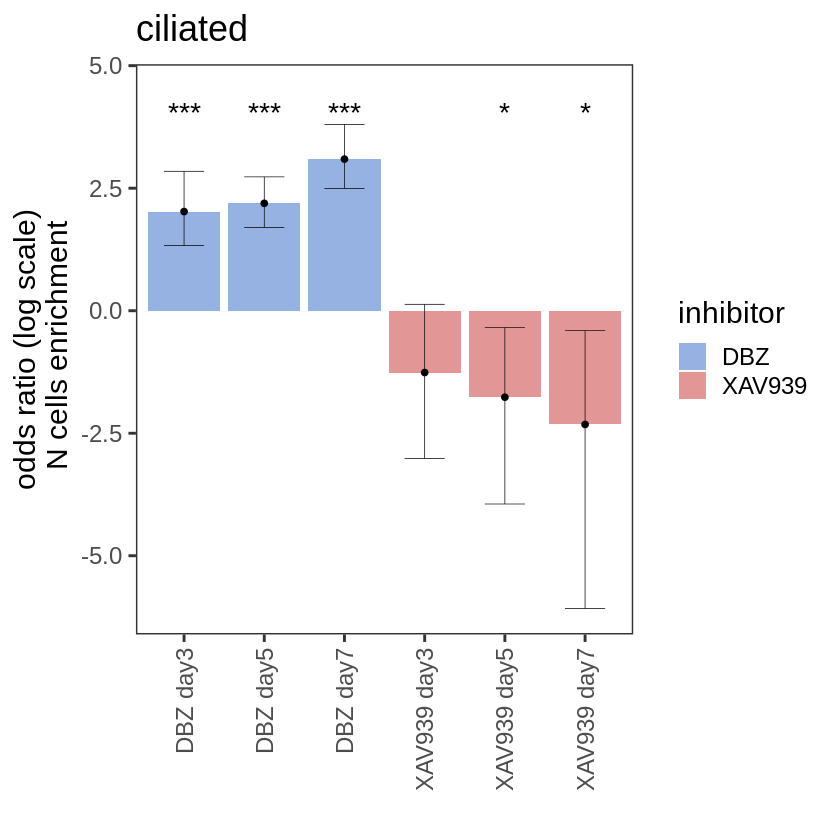

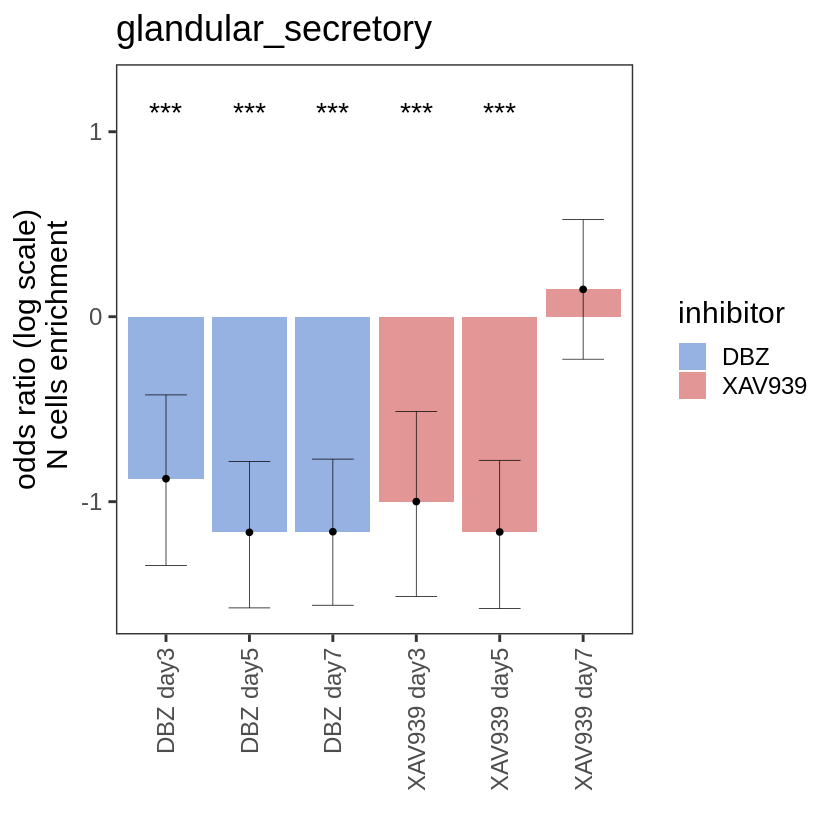

$proliferative

$inter_PGRneg

$inter

$KRT5_LRG6

$inter_PGRpos

$KRT5_KRT13

$ciliated

$glandular_secretory

$new_secretory

$secretory_cycling


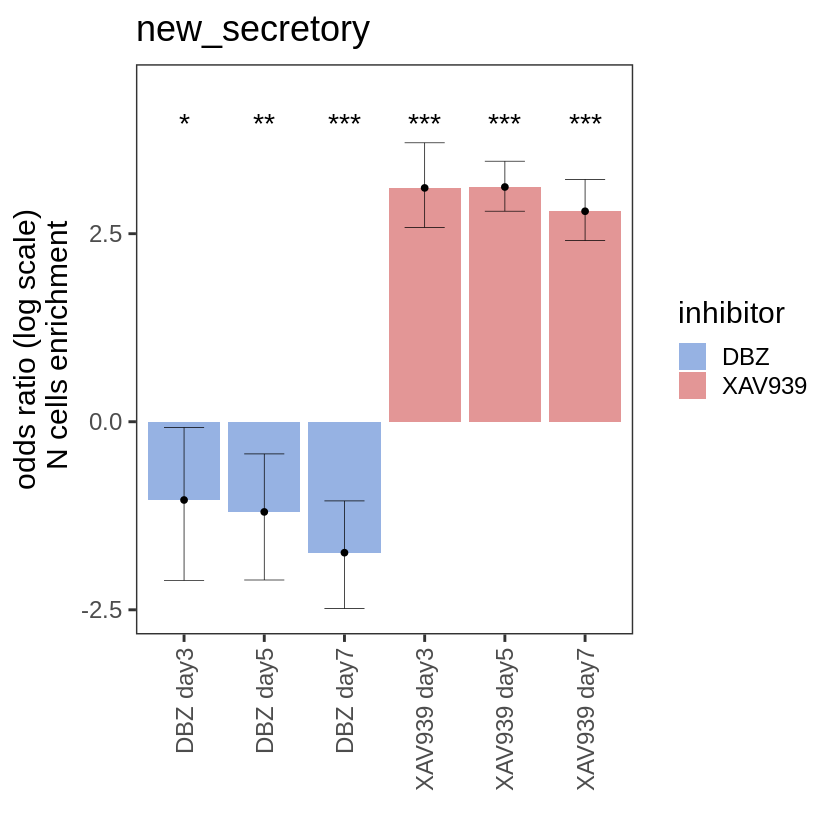

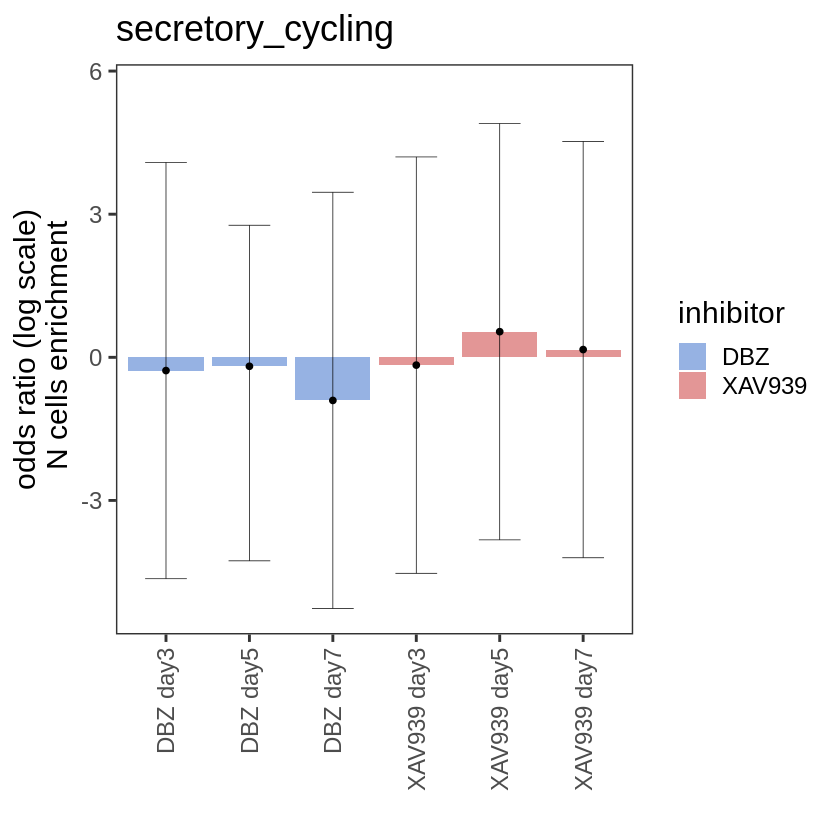

In [13]:
inhibitors = setdiff(metadata$Inhibition, 'N/I')
times = c(3, 5, 7)
R = list()
for (cl in unique(metadata$clusters))
    R[[cl]] = test_cluster(cl)
R